<a href="https://colab.research.google.com/github/goto-c/psychic-umbrella/blob/master/cloth3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データセットの用意

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torchvision import transforms
from PIL import Image
from os.path import join
from torch.utils.data import random_split


# MyDatasetクラス
import torch
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data_num=5016, mode='train', root_dir='/content/drive/My Drive/cloth_data', transform=None):

        self.data_num = data_num
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform

        self.train_num = 3600
        self.val_num = 900
        self.test_num = 516

        self.data_name = ['{}.png'.format(i) for i in range(data_num)]

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):

        a_path = join(self.root_dir, 'a', self.data_name[idx])
        b_path = join(self.root_dir, 'b', self.data_name[idx])
        a_img = Image.open(a_path).convert('RGB')
        b_img = Image.open(b_path).convert('RGB')

        if self.transform:
            a_img = self.transform(a_img)
            b_img = self.transform(b_img)

        return a_img, b_img



transform = transforms.ToTensor()

data_set = MyDataset(transform=transform)
data_nums = [4000, 1000, 16]
train_set, val_set, test_set = random_split(data_set, data_nums)

batch_size = 1 #160*minibatch
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

#for i, (a, b) in enumerate(train_loader):
#  print(i, '----------')
#  print('a.shape: ', a.shape)
#  print('b.shape: ', b.shape)

#a, b = next(iter(train_loader))
#print(a.shape)
#print(b.shape)
#print('a.shape: ', a.shape) torch.Size([1, 3, 256, 256])
#print('b.shape: ', b.shape) torch.Size([1, 3, 256, 256])

# U-Netモデルのクラスを定義

In [0]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [0]:
pic_dir = '/content/drive/My Drive/cloth_data/unet.png'
img = Image.open(pic_dir)
#img

# 学習

In [0]:
# loss モジュール

import torch
import torch.nn as nn

def dice_loss(output, b, smooth=1.): # output / b = torch.Size([1, 3, 256, 256])
  output = output.contiguous() 
  b = b.contiguous()

  intersection = (output * b).sum(dim=2).sum(dim=2)
  #print('intersection.shape: ', intersection.shape)
  # intersection.shape = torch.Size([1, 3])

  #print('test: ', output.sum(dim=2).sum(dim=2).shape)
  # output.sum2.sum2 = torch.Size([1, 3])
 
  loss = (1 - ((2. * intersection + smooth) / (output.sum(dim=2).sum(dim=2) + b.sum(dim=2).sum(dim=2) + smooth)))
  #print('loss: ', loss)

  return loss.mean()

In [94]:
import torch.nn.functional as F
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device: ', device)

model = UNet(3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
num_epochs = 50

t_loss = []
v_loss = []
for epoch in range(num_epochs):
  torch.cuda.empty_cache()
  print('-' * 10)
  print('Epoch {}/{}'.format(epoch+1, num_epochs))

  # training start
  scheduler.step()
  model.train()

  metrics = defaultdict(float)
  epoch_samples = 0

  t_num = 1
  for a, b in train_loader:
    #if t_num % 1000 == 0:
    #  print('tbatch_num: {}/{}'.format(t_num, 4000//batch_size))
    t_num += 1
    a = a.to(device)
    b = b.to(device)
    #print(a.shape)
    #print(b.shape)
    #torch.Size([1, 3, 256, 256])
    #torch.Size([1, 3, 256, 256])

    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      output = model(a)

      #print('output size: ', output.shape)
      # output.shape = torch.Size([1, 3, 256, 256])

      #calculate loss
      bce = F.binary_cross_entropy_with_logits(output, b) 
      #print('bce: ', bce)
      # bce = tensor(0.6932, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

      output = F.sigmoid(output) # torch.sigmoid を使えとwarningが出るが、F.sigmoidを使わないと学習が進まなくなる。
      #print('output.shape: ', output.shape)
      # output.shape = torch.Size([1, 3, 256, 256])

      dice = dice_loss(output, b)
      #print('dice_loss: ', dice)

      bce_weight = 0.5
      loss = bce * bce_weight + dice * (1 - bce_weight)

      metrics['bce'] += bce.data.cpu().numpy() * b.size(0)
      metrics['dice'] += dice.data.cpu().numpy() * b.size(0)
      metrics['loss'] += loss.data.cpu().numpy() * b.size(0)

      loss.backward()
      optimizer.step()
      #scheduler.step()

  # print matrics
  epoch_samples += a.size(0)
  #print('a.size(0): ', a.size(0))
  outputs = []
  for k in metrics.keys():
    outputs.append('{}:　{:4f}'.format(k, metrics[k] / (epoch_samples*(4000//batch_size))))
  print('train ::: {}'.format(',　'.join(outputs)))
  t_loss.append(metrics[k] / epoch_samples*(4000//batch_size))


    # validation start
  torch.cuda.empty_cache()
  model.eval()

  metrics = defaultdict(float)
  epoch_samples = 0

  v_num = 1
  for a, b in val_loader:
    #if v_num % ((1000//batch_size)//10) == 0:
    #  print('vbatch_num: {}/{}'.format(v_num, 1000//batch_size))
    v_num += 1
    a = a.to(device)
    b = b.to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
      output = model(a)

      # calculate loss
      bce = F.binary_cross_entropy_with_logits(output, b)

      output = F.sigmoid(output)
      dice = dice_loss(output, b)

      loss = bce * bce_weight + dice * (1 - bce_weight)

      metrics['bce'] += bce.data.cpu().numpy() * b.size(0)
      metrics['dice'] += dice.data.cpu().numpy() * b.size(0)
      metrics['loss'] += loss.data.cpu().numpy() * b.size(0)

    # print metrics
  epoch_samples += a.size(0)
  outputs = []
  for k in metrics.keys():
    outputs.append('{}:　{:4f}'.format(k, metrics[k] / (epoch_samples*(1000//batch_size))))
  print('val   ::: {}'.format(',　'.join(outputs)))
  v_loss.append(metrics[k] / epoch_samples*(1000//batch_size))

device:  cuda
----------
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train ::: bce:　0.122913,　dice:　0.299684,　loss:　0.211299
val   ::: bce:　0.119530,　dice:　0.282885,　loss:　0.201208
----------
Epoch 2/50
train ::: bce:　0.115287,　dice:　0.284376,　loss:　0.199832
val   ::: bce:　0.118678,　dice:　0.276484,　loss:　0.197581
----------
Epoch 3/50
train ::: bce:　0.113713,　dice:　0.280841,　loss:　0.197277
val   ::: bce:　0.113183,　dice:　0.278978,　loss:　0.196081
----------
Epoch 4/50
train ::: bce:　0.112830,　dice:　0.278596,　loss:　0.195713
val   ::: bce:　0.117684,　dice:　0.274563,　loss:　0.196123
----------
Epoch 5/50
train ::: bce:　0.112091,　dice:　0.276768,　loss:　0.194429
val   ::: bce:　0.114077,　dice:　0.274257,　loss:　0.194167
----------
Epoch 6/50
train ::: bce:　0.111554,　dice:　0.275204,　loss:　0.193379
val   ::: bce:　0.112791,　dice:　0.274265,　loss:　0.193528
----------
Epoch 7/50
train ::: bce:　0.111058,　dice:　0.273815,　loss:　0.192437
val   ::: bce:　0.118310,　dice:　0.267762,　loss:　0.193036
----------
Epoch 8/50
train ::: bce:　0.110660,　dice:　0.272611,　loss:　0.191635
val   

[3380780.7512283325, 3197305.1940202713, 3156437.686920166, 3131405.624896288, 3110869.1473305225, 3094064.532071352, 3078988.7786209583, 3066163.134634495, 3053834.239691496, 3042761.8538439274, 3031902.764171362, 3022390.677601099, 3013682.827949524, 3004720.725417137, 2997053.5013079643, 2989781.8636000156, 2982797.936052084, 2976538.173854351, 2971076.537668705, 2965405.513882637, 2960472.22879529, 2955564.082503319, 2952389.0060782433, 2947595.898270607, 2931949.2838978767, 2927164.7325456142, 2924885.1761221886, 2923195.6406235695, 2921785.6874465942, 2920535.253494978, 2919407.711774111, 2918369.62851882, 2917377.558529377, 2916425.6959855556, 2915550.9273707867, 2914694.2996382713, 2913859.594553709, 2913064.053684473, 2912292.696118355, 2911565.185725689, 2910839.442074299, 2910135.322213173, 2909454.6335041523, 2908792.5248146057, 2908160.124450922, 2907525.0558555126, 2906919.749379158, 2906329.5835852623, 2905748.7653791904, 2904149.187684059]
[201207.66948908567, 197580.63

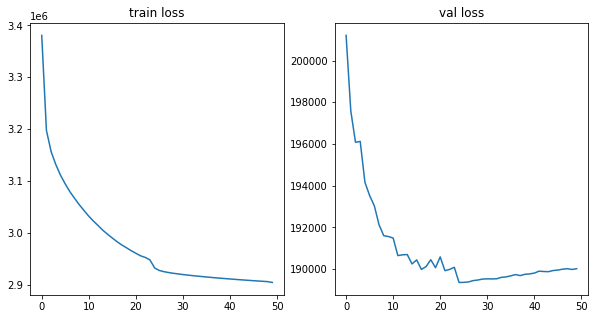

In [95]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(t_loss))
plt.figure(figsize=(10,5))
fig1 = plt.subplot(1,2,1)
fig1.plot(x, t_loss)
plt.title('train loss')
fig2 = plt.subplot(1,2,2)
fig2.plot(x, v_loss)
plt.title('val loss')

print(t_loss)
print(v_loss)

# 予測

In [0]:
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def reverse_transform(inp):
  inp = inp.numpy().transpose((1,2,0))
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

#def masks_to_colorimg(masks): # masks = torch.Size([3, 256, 256])
    #colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])
    #print('colors:')
    #[[201  58  64]
    # [242 207   1]
    # [  0 152  75]
    # [101 172 228]
    # [ 56  34 132]
    # [160 194  56]]
    #print(colors)
    #colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    #print('colorimg.shape: ', colorimg.shape)
    # colorimg.shape = (256, 256, 3), value = 255
    #channels, height, width = masks.shape
    # channels, height, width = (3, 256, 256)

    #for y in range(height):
    #    for x in range(width):
            #print('masks[:,x,y]: ', masks[:,x,y]) # masks[:,x,y]:  tensor([0.2275, 0.5922, 0.9059])
            #print('colors[masks[:,x,y] > [0.5, 0.5, 0.5]: ', colors[masks[:,y,x] > [0.5, 0.5, 0.5]])
            #selected_colors = colors[masks[:,y,x] > 0.5]
            #selected_colors = colors[0]
            #print('selected_colors: ', selected_colors)

            #if len(selected_colors) > 0:
            #    colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    #return colorimg.astype(np.uint8)

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

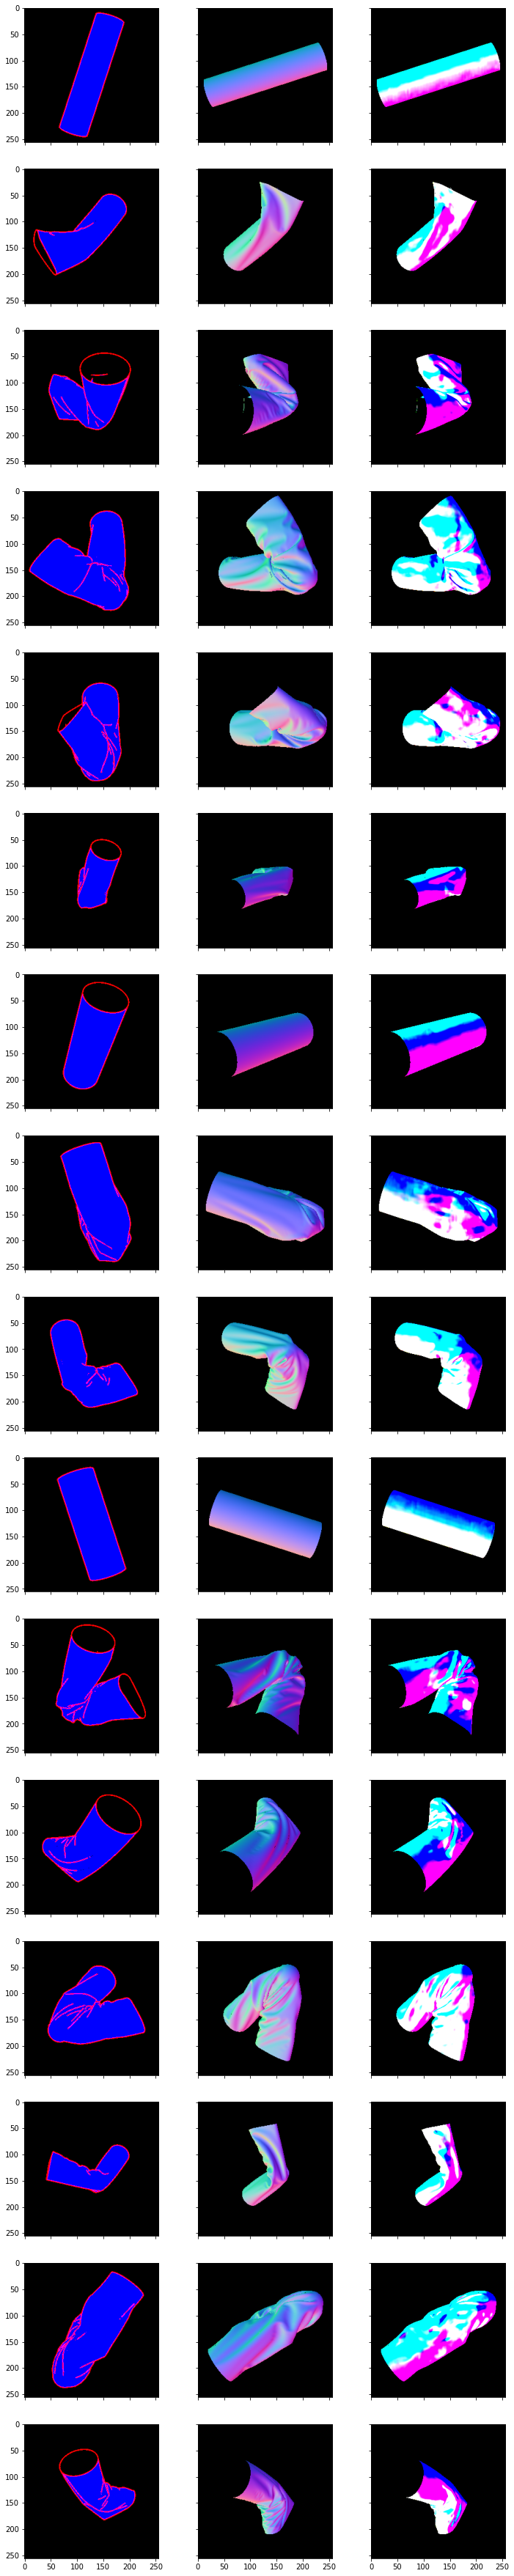

In [97]:
import math

torch.cuda.empty_cache()

model.eval()
a, b = next(iter(test_loader))
a = a.to(device)
b = b.to(device)

output = model(a) # aをモデルに通してoutputを得る

output = output.data.cpu().numpy() # outputをcpuに送り、numpy配列に変換
#print(output.shape)

#print(a.cpu)
#print(a.cpu().shape)
#masks_to_colorimg(b.cpu()[0])
input_images_rgb = [reverse_transform(x) for x in a.cpu()] # a を転置する

target_masks_rgb = [x.T for x in b.cpu().numpy()]
#target_masks_rgb = [masks_to_colorimg(x) for x in b.cpu().numpy()]
pred_rgb = [x.T for x in output]
#pred_rgb = [masks_to_colorimg(x) for x in output]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [86]:
im = Image.fromarray(input_images_rgb[0])
dst_a = Image.new('RGB', (im.width*len(input_images_rgb), im.height))
dst_b = Image.new('RGB', (im.width*len(target_masks_rgb), im.height))
dst_c = Image.new('RGB', (im.width*len(pred_rgb), im.height))

for i in range(len(input_images_rgb)):
  dst_a.paste(input_images_rgb[i], (im.width * i, 0))
  dst_b.paste(target_masks_rgb[i], (im.width * i, 0))
  dst_c.past(pred_rgb[i], (im.width * i, 0))

ValueError: ignored

### train, val, test に分けない仕様のDatasetクラス

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torchvision import transforms
from PIL import Image
from os.path import join


# MyDatasetクラス
import torch
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data_num=5016, mode='train', root_dir='/content/drive/My Drive/cloth_data', transform=None):

        self.data_num = data_num
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform

        self.train_num = 3600
        self.val_num = 900
        self.test_num = 516

        self.data_name = ['{}.png'.format(i) for i in range(data_num)]

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):

        a_path = join(self.root_dir, 'a', self.data_name[idx])
        b_path = join(self.root_dir, 'b', self.data_name[idx])
        a_img = Image.open(a_path)
        b_img = Image.open(b_path)

        if self.transform:
            a_img = self.transform(a_img)
            b_img = self.transform(b_img)

        return a_img, b_img



transform = transforms.ToTensor()

data_set = MyDataset(transform=transform)

batch_size = 1
dataloader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False)


# データサイズが[1, 256, 256]になってしまうバグの対処

bag_idx = []
bag_image = []
for i, (a, b) in enumerate(dataloader):
  #print(a.shape)
  #print(a.shape[0], a.shape[1], a.shape[2], a.shape[3])
  if a.shape[1] == 1:
    bag_idx.append(i)
    bag_image.append('{}.png'.format(i))
  #if i>100:
  #  break

print(bag_idx)
print(bag_image)

  #print(i, ' ----------')
  #print('a.shape: ', a.shape)
  #print('b.shape: ', b.shape)
  #if a.shape[1] == 1:
  #  root = '/content/drive/My Drive/cloth_data'
  #  apath = join(root, 'a', '{}.png'.format(i))
  #  bpath = join(root, 'b', '{}.png'.format(i))
  #  imga = Image.open(apath)
  #  imgb = Image.open(bpath)
  #  imga

#a, b = next(iter(dataloader))
#print(a.shape)
#print(b.shape)
#print('a.shape: ', a.shape)
#print('b.shape: ', b.shape)

[9, 12, 18, 21, 204, 213, 453, 777, 942, 957, 1260, 1329, 1338, 1467, 1482, 1485, 1626, 2721, 2886, 3399, 3402, 3849, 3852, 4857]
['9.png', '12.png', '18.png', '21.png', '204.png', '213.png', '453.png', '777.png', '942.png', '957.png', '1260.png', '1329.png', '1338.png', '1467.png', '1482.png', '1485.png', '1626.png', '2721.png', '2886.png', '3399.png', '3402.png', '3849.png', '3852.png', '4857.png']


In [0]:
# Image.open(img).convert('RGB')により、サイズを 1,256,256 から 3,256,256 に揃えられることを確認！

root = '/content/drive/My Drive/cloth_data'
impath = join(root, 'a', bag_image[0])
im = Image.open(impath)
im_con = Image.open(impath).convert('RGB')

from torchvision import transforms
trans = transforms.ToTensor()

im = trans(im)
im_con = trans(im_con)
print(im.shape)
print(im_con.shape)

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


In [0]:
# バグが発生している画像インスタンスを、imga_list, imgb_list に追加
imga_list = []
imgb_list = []
for i in range(len(bag_idx)):
  apath = join(root, 'a', bag_image[i])
  bpath = join(root, 'b', bag_image[i])
  imga = Image.open(apath)
  imgb = Image.open(bpath)
  imga_list.append(imga)
  imgb_list.append(imgb)

In [0]:
# imga_list と imgb_list　に格納された画像を横に並べて表示
im = imga_list[0]
dst_a = Image.new('RGB', (im.width*len(imga_list), im.height))
dst_b = Image.new('RGB', (im.width*len(imgb_list), im.height))

for i in range(len(imga_list)):
  dst_a.paste(imga_list[i], (im.width * i, 0))
  dst_b.paste(imgb_list[i], (im.width * i, 0))

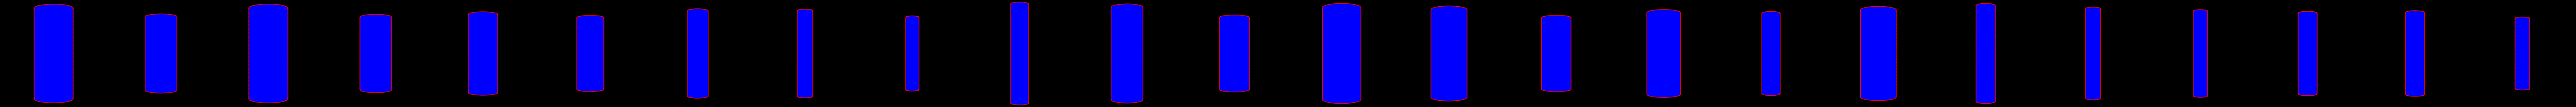

In [0]:
dst_a

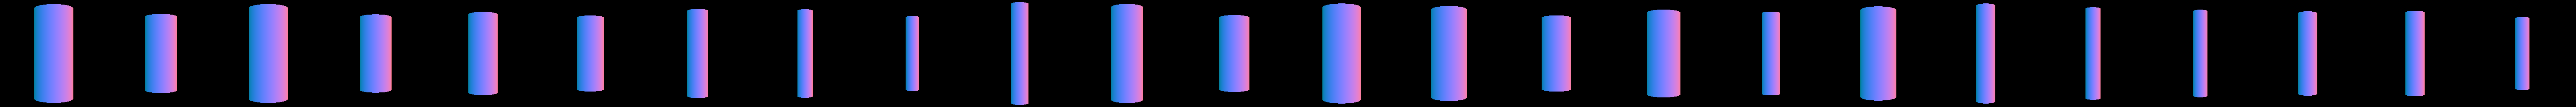

In [0]:
dst_b

### convert('RGB')をつけて再チャレンジ

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torchvision import transforms
from PIL import Image
from os.path import join


# MyDatasetクラス
import torch
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data_num=5016, mode='train', root_dir='/content/drive/My Drive/cloth_data', transform=None):

        self.data_num = data_num
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform

        self.train_num = 3600
        self.val_num = 900
        self.test_num = 516

        self.data_name = ['{}.png'.format(i) for i in range(data_num)]

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):

        a_path = join(self.root_dir, 'a', self.data_name[idx])
        b_path = join(self.root_dir, 'b', self.data_name[idx])
        a_img = Image.open(a_path)
        b_img = Image.open(b_path)

        if self.transform:
            a_img = self.transform(a_img)
            b_img = self.transform(b_img)

        return a_img, b_img



transform = transforms.ToTensor()

data_set = MyDataset(transform=transform)

batch_size = 1
dataloader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False)


# データサイズが[1, 256, 256]になってしまうバグの対処

bag_idx = []
bag_image = []
for i, (a, b) in enumerate(dataloader):
  #print(a.shape)
  #print(a.shape[0], a.shape[1], a.shape[2], a.shape[3])
  if a.shape[1] == 1:
    bag_idx.append(i)
    bag_image.append('{}.png'.format(i))
  if i>100:
    break

print(bag_idx)
print(bag_image)

  #print(i, ' ----------')
  #print('a.shape: ', a.shape)
  #print('b.shape: ', b.shape)
  #if a.shape[1] == 1:
  #  root = '/content/drive/My Drive/cloth_data'
  #  apath = join(root, 'a', '{}.png'.format(i))
  #  bpath = join(root, 'b', '{}.png'.format(i))
  #  imga = Image.open(apath)
  #  imgb = Image.open(bpath)
  #  imga

#a, b = next(iter(dataloader))
#print(a.shape)
#print(b.shape)
#print('a.shape: ', a.shape)
#print('b.shape: ', b.shape)

[9, 12, 18, 21]
['9.png', '12.png', '18.png', '21.png']


In [0]:
# バグが発生している画像インスタンスを、imga_list, imgb_list に追加
imga_list = []
imgb_list = []
for i in range(len(bag_idx)):
  apath = join(root, 'a', bag_image[i])
  bpath = join(root, 'b', bag_image[i])
  imga = Image.open(apath).convert('RGB')
  imgb = Image.open(bpath).convert('RGB')
  imga_list.append(imga)
  imgb_list.append(imgb)

In [0]:
# imga_list と imgb_list　に格納された画像を横に並べて表示
im = imga_list[0]
dst_a = Image.new('RGB', (im.width*len(imga_list), im.height))
dst_b = Image.new('RGB', (im.width*len(imgb_list), im.height))

for i in range(len(imga_list)):
  dst_a.paste(imga_list[i], (im.width * i, 0))
  dst_b.paste(imgb_list[i], (im.width * i, 0))

In [0]:
for i in range(len(imga_list)):
  print(imga_list[i])

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F182BE6D7B8>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F182BE75B00>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F182BE750B8>
<PIL.Image.Image image mode=RGB size=256x256 at 0x7F182BE759E8>


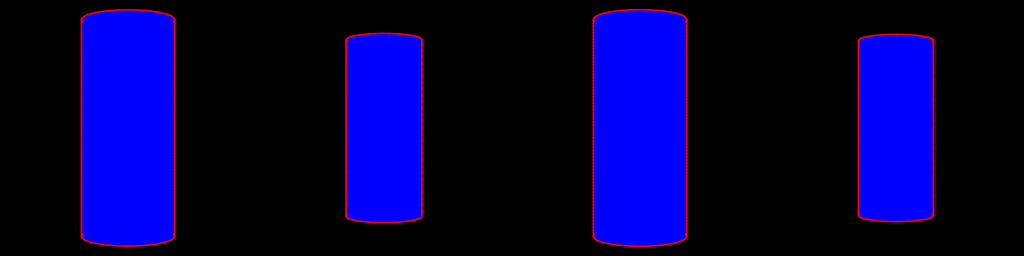

In [0]:
dst_a

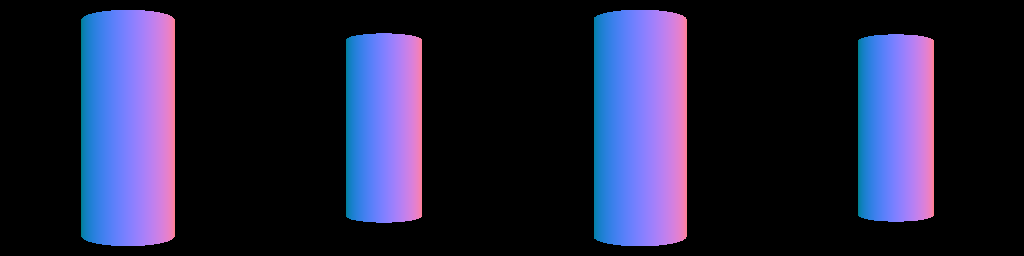

In [0]:
dst_b

In [0]:
from PIL import Image
from os.path import join
from torchvision import transforms
root = '/content/drive/My Drive/cloth_data'
a_path = join(root, 'a', '0.png')
b_path = join(root, 'b', '0.png')
imga = Image.open(a_path)
imgb = Image.open(b_path)
trans = transforms.ToTensor()
imga = trans(imga)
imgb = trans(imgb)
print(imga.shape)
print(imgb.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [0]:
dataset = MyDataset(transform=trans)

In [0]:
a, b = dataset[0]

In [0]:
print(a.shape)
print(b.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [0]:
import torch
img = torch.stack([a, b], axis=0)
img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [0]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

In [0]:
a, b = next(iter(dataloader))

In [0]:
a

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [0]:
a.shape

torch.Size([24, 3, 256, 256])

In [0]:
b.shape

torch.Size([24, 3, 256, 256])

In [0]:
c, d = next(iter(dataloader))

In [0]:
c

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [0]:
c.shape

torch.Size([24, 3, 256, 256])

In [0]:
d.shape

torch.Size([24, 3, 256, 256])

In [0]:
!nvidia-smi

Mon May  4 12:27:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  